# 概念

## 非参注意力池化层

Nadaraya-waston 回归

公式中的K表示核函数：用于衡量相似度的手段。做归一化之后，算出来的就是相对的重要度。



$$f(x)=\sum^{n}_{i=1} \frac{K(x-x_i)}{\sum^{n}_{j=1}K(x-x_j)}y_i\tag{1}$$


整体的含义大致是这样子： 一堆数据X拿进来的时候，对于每个x, 我都需要计算如下 我看中的两方面：

1. X中跟我相近的那些数据（对应的权重高）

2. 样本本身的value高



如果是高斯核，那么u就是距离

$$K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})\tag{2}$$

将公式2套入到1中，可以推导出来：

$$f(x)=\sum_{i=1}^{n}softmax(-\frac{1}{2}(x-x_i)^2)y_i\tag{3}$$

机器学习总是要学点什么东西的，我们需要将公式3参数化，加入可以学习的w

$$f(x)=\sum_{i=1}^{n}softmax(-\frac{1}{2}((x-x_i)w)^2)y_i\tag{4}$$

## 总结

- 过去的模型，总是给我什么我去看什么；在注意力机制中，引入query和key来进行有偏向的选择

- 关于权重设计，有很多不同的设计方法，上面只是给出一个例子

# coding

In [4]:
import torch
from torch import nn

## 2.1 生成数据集

In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

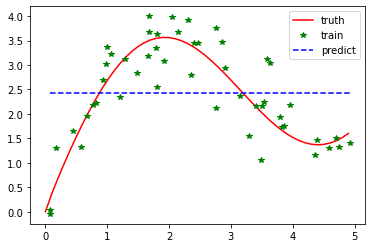

In [15]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, 'r-', label='truth')
    plt.plot(x_train, y_train, 'g*', label='train')
    plt.plot(x_train, y_hat, 'b--', label='predict')
    plt.legend()
    
# 先用最简单的估计看看数据
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 2.2 非参数注意力pooling

In [24]:
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
X_repeat.shape

torch.Size([50, 50])

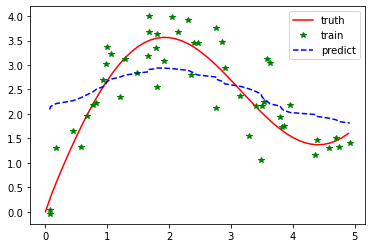

In [22]:
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2/2, dim=1)
y_hat = attention_weights @ y_train
plot_kernel_reg(y_hat)

使用测试数据的input，直接与所有的训练数据（key）进行距离计算，套上softmax输出attention矩阵， 然后乘训练数据的y（value），输出对应的query

其实就是根据query与每一个样本的距离作为权重，对样本的value进行加权平均。

In [31]:
attention_weights.unsqueeze(0).shape

torch.Size([1, 50, 50])

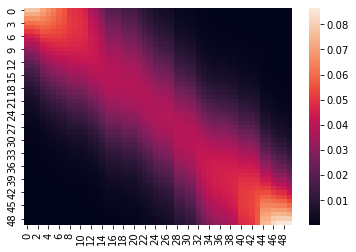

In [39]:
import seaborn as sns
axis = sns.heatmap(attention_weights)

本例中，测试数据的输入，相当与query， 训练数据相当于key，因为都是排序过的，所以<query-key>距离越近，输出weight越高

## 2.3 带参注意力pooling

w本质是控制高斯Kernel的窗口宽度

首先熟悉下bmm操作，也是矩阵乘法，但是第一个维度是batch

In [43]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))

In [45]:
weights.shape, values.shape

(torch.Size([2, 10]), torch.Size([2, 10]))

In [47]:
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # (2, 1, 10) @ (2, 10, 1)

tensor([[[ 4.5000]],

        [[14.5000]]])

### 2.3.1 定义模型

In [107]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        # todo: about **kargs
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,)), requires_grad=True)
        
    def forward(self, queries, keys, values):
        
        # queries x_train shape(50, 49)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        
        self.attention_weights = nn.functional.softmax(-((queries - keys)*self.w)**2/2, dim=1)
        # (50 * 1* 49) * (50 * 49 * 1)
        # output 50
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

## 2.3.2 训练

In [101]:
# 每一行都包含相同的input
X_tile = x_train.repeat((n_train, 1))

Y_tile = y_train.repeat((n_train, 1))

# 剔除与自己相同的元素 shape = (n_train, n_train - 1)
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)

values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)

keys.shape, values.shape

(torch.Size([50, 49]), torch.Size([50, 49]))

In [108]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)


for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(epoch, l.sum())    

0 tensor(34.3987, grad_fn=<SumBackward0>)
1 tensor(14.8868, grad_fn=<SumBackward0>)
2 tensor(14.8857, grad_fn=<SumBackward0>)
3 tensor(14.8847, grad_fn=<SumBackward0>)
4 tensor(14.8838, grad_fn=<SumBackward0>)


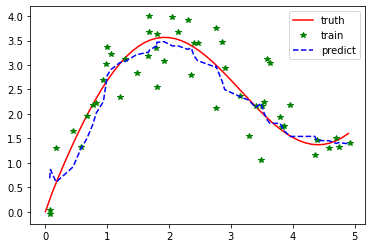

In [102]:
y_hat = net(x_test, keys, values).unsqueeze(1).detach()

plot_kernel_reg(y_hat)

In [112]:
net.state_dict()

OrderedDict([('w', tensor([4.0131]))])

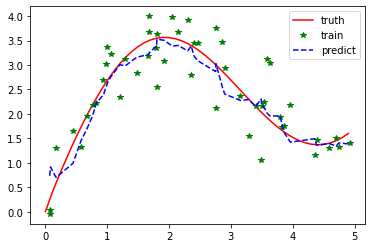

In [109]:
# 使用一个权重w
y_hat = net(x_test, keys, values).unsqueeze(1).detach()

plot_kernel_reg(y_hat)

In [104]:
y_hat.shape, net.attention_weights.shape

(torch.Size([50, 1]), torch.Size([50, 49]))

<AxesSubplot:>

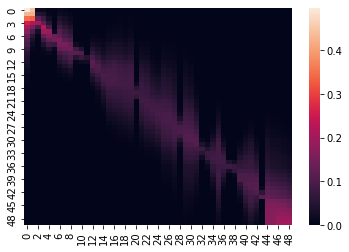

In [106]:
sns.heatmap(net.attention_weights.detach())